In [1]:
# If you run on google colab uncomment bellow comment
# !pip install torchmetrics pytorch-lightning torchvision -qq
# !pip install imutils

import copy
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from math import *

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchmetrics import Accuracy

import lightning as pl # Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from lightning.pytorch.callbacks.progress import RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme
from torchvision.models import vit_b_16, ViT_B_16_Weights


import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

BATCH_SIZE = 256 if torch.cuda.is_available() else 48
# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
print(device)
num_workers = 16 # Set to your device

import json

torch.set_float32_matmul_precision('medium')

cuda:0


In [2]:
data_transforms_none = transforms.Compose([
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    transforms.Resize([200,200])
])
train_ds = torchvision.datasets.ImageFolder("./data/imgs/train/",transform=data_transforms_none)

def norm_stats(ds):
    L=len(ds)
    mean_total = np.zeros(3)
    std_total = np.zeros(3)
    for i in range(L):
        img = (ds.__getitem__(i))[0].numpy()
        img = img.reshape(img.shape[0],img.shape[1]*img.shape[2])

        mean_total += np.mean(img,axis=1)
        std_total += np.std(img,axis=1)

    means = (mean_total/L).tolist()
    stds = (std_total/L).tolist()

    return means, stds    

In [2]:
# means, stds = norm_stats(train_ds)

#Output from above line
means = [0.6599775287756063, 0.5283674328647204, 0.26714183714726647]
stds = [0.1317305792557695, 0.16583433406217096, 0.3081538652392283]

print(means)
print(stds)

[0.6599775287756063, 0.5283674328647204, 0.26714183714726647]
[0.1317305792557695, 0.16583433406217096, 0.3081538652392283]


In [3]:
data_transforms = transforms.Compose([
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    transforms.Resize([224,224]),
    transforms.Normalize(means, stds)
])

def train_transform(x,y):
    rand1 = np.random.rand()
    if rand1>0.5:
        x = transforms.functional.hflip(x)

        if y == 1:
            y=2
        elif y==2:
            y=1
        
    return x,y

In [4]:
# class OCData(torchvision.datasets.ImageFolder):
#     # Dataset Class
#     def __init__(self, path, transform = None, target_transform=None):
#         super(OCData, self).__init__(root=path)
#         self.target_transform = target_transform

#     def __getitem__(self, index):
#         path, target = self.samples[index]
#         sample = self.loader(path)

#         if self.transform is not None:
#             sample = self.transform(sample)
#         if self.target_transform is not None:
#             sample, target = self.target_transform(sample,target)


#         return sample, target
    
    
# train_set = OCData("./data/imgs/train/",transform=data_transforms,target_transform = train_transform)
# test_set = OCData("./data/imgs/test/",transform=data_transforms)
# val_set = OCData("./data/imgs/val/",transform=data_transforms)

train_set = torchvision.datasets.ImageFolder("./data/imgs/train/",transform=data_transforms)
test_set = torchvision.datasets.ImageFolder("./data/imgs/test/",transform=data_transforms)
val_set = torchvision.datasets.ImageFolder("./data/imgs/val/",transform=data_transforms)

# Create Dataloaders again with features generated from pre-trained CNN model
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, persistent_workers=True)
valid_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, persistent_workers=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

In [5]:
print(vit_b_16(weights=ViT_B_16_Weights))

c:\Users\shelb\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [6]:
class ResNet_Model(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, num_classes=5):
        super().__init__()
        self.learning_rate = learning_rate 
        self.criterion = nn.CrossEntropyLoss()  ## Define your loss! What should it be?
        
        ## Load the pre-trained network as follows
        ## vit_b_16 from models
        ## Use the importedweights of:   ViT_B_16_Weights.IMAGENET1K_V1
        ## See pytorch documentation on how to load models with a pre-trained weight
        self.resnet = vit_b_16(weights=ViT_B_16_Weights)## Load the pre-trained network as follows
        ## Freeze vit_b_16 weights (see PDF's hints)
        ## You can set the param.requires_grad = False 
        ## That way those parameters will not get updated
        self.resnet.requires_grad_(False)

        ## Remake the vit_b_16 FC layer. You can use the in_features from the original model 
        self.resnet.heads= nn.Linear(768,num_classes)

        ## Which error do we use? Remember, we are dealing with minimising coordinate errors in the landmarks
        self.val_error = nn.CrossEntropyLoss()
        self.train_error = nn.CrossEntropyLoss()
        self.test_error = nn.CrossEntropyLoss()
        # Define your accuracies        
        self.train_accuracy = Accuracy(task="multiclass",num_classes=num_classes)
        self.val_accuracy = Accuracy(task="multiclass",num_classes=num_classes)
        self.test_accuracy = Accuracy(task="multiclass",num_classes=num_classes)
            
    def forward(self, x):
        #Pass input through the model
        x_out = self.resnet(x)
    
        return x_out
    
    def training_step(self, batch, batch_idx):
        x, y= batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Compute accuracy
        preds = logits.argmax(1)
        self.train_accuracy.update(preds, y)
        acc = self.train_accuracy.compute()

        # Record accuracy and loss
        # Log anything you think necessary
        train_dict = {"train_loss": loss,
                    "train_acc": acc,
                    "epoch": self.current_epoch}
        
        self.log_dict(train_dict, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y= batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Compute accuracy
        preds = logits.argmax(1)
        self.val_accuracy.update(preds, y)
        acc = self.val_accuracy.compute()

        # Record accuracy and loss
        # Log anything you think necessary
        val_dict = {"val_loss": loss,
                    "val_acc": acc,
                    "epoch": self.current_epoch}
        
        self.log_dict(val_dict, prog_bar=True, on_step=False, on_epoch=True)
    
        

    def test_step(self, batch, batch_idx):
        x, y= batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Compute accuracy
        preds = logits.argmax(1)
        self.test_accuracy.update(preds, y)
        acc = self.test_accuracy.compute()

        # Record accuracy and loss
        # Log anything you think necessary
        test_dict = {"test_loss": loss,
                    "test_acc": acc,
                    "epoch": self.current_epoch}
        
        self.log_dict(test_dict, prog_bar=True, on_step=False, on_epoch=True)

        return preds, logits, x, y
    
    def predict_step(self, batch, batch_idx):
        x, y= batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Compute accuracy
        preds = logits.argmax(1)
        print(preds)
        self.test_accuracy.update(preds, y)

        return preds, logits, x, y

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        return train_loader
    
    def val_dataloader(self):
        return valid_loader

    def test_dataloader(self):
        return test_loader

In [7]:
# Initialize the CNN model
max_epochs = 100 # Feel free to change this
model_cnn = ResNet_Model()

# Initialize checkpoint callback to save the best model using validation loss
checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints_section/v3/",
        save_top_k=1,        
        mode="min",
        every_n_epochs=1
    )

# Create customized progress bar theme (Optional)
progress_bar_task = RichProgressBar(refresh_rate=1, leave=True,
    theme=RichProgressBarTheme(
        description="green_yellow",
        progress_bar="green1",
        progress_bar_finished="green1",
        progress_bar_pulse="#6206E0",
        batch_progress="green_yellow",
        time="grey82",
        processing_speed="grey82",
        metrics="grey82"
    )
)

# Call the Trainer and train the model
early_stopping = EarlyStopping('val_loss', patience = 10, mode = 'min')

trainer_task = pl.Trainer(
    accelerator="auto",#"cpu",
    devices=1, #if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=max_epochs,
    callbacks=[progress_bar_task, checkpoint_callback,early_stopping],
    logger=CSVLogger(save_dir="logs_task/v3/"),
    precision=32
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
trainer_task.fit(model_cnn)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name           ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ criterion      │ CrossEntropyLoss   │      0 │
│ 1 │ resnet         │ VisionTransformer  │ 85.8 M │
│ 2 │ val_error      │ CrossEntropyLoss   │      0 │
│ 3 │ train_error    │ CrossEntropyLoss   │      0 │
│ 4 │ test_error     │ CrossEntropyLoss   │      0 │
│ 5 │ train_accuracy │ MulticlassAccuracy │      0 │
│ 6 │ val_accuracy   │ MulticlassAccuracy │      0 │
│ 7 │ test_accuracy  │ MulticlassAccuracy │      0 │
└───┴────────────────┴────────────────────┴────────┘

Trainable params: 3.8 K                                                                                            
Non-trainable params: 85.8 M                                                                                       
Total params: 85.8 M                                                                                               
Total estimated model params size (MB): 343

Output()

c:\Users\shelb\anaconda3\envs\pytorch\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\resul
t.py:212: UserWarning: You called `self.log('epoch', ...)` in your `validation_step` but the value needs to be 
floating point. Converting it to torch.float32.
  warning_cache.warn(

c:\Users\shelb\anaconda3\envs\pytorch\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\resul
t.py:212: UserWarning: You called `self.log('epoch', ...)` in your `training_step` but the value needs to be 
floating point. Converting it to torch.float32.
  warning_cache.warn(

Output()

Output()

Output()

c:\Users\shelb\anaconda3\envs\pytorch\Lib\site-packages\lightning\pytorch\trainer\call.py:53: UserWarning: Detected
KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")

In [7]:
# torch.save(model_cnn,"./models/v3/model_0.pt")
# model_cnn = torch.load("./models/v2/model_0.pt")

In [13]:
trainer_task.test(model_cnn,test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Dylan\anaconda3\envs\pytorch\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.
c:\Users\Dylan\anaconda3\envs\pytorch\Lib\site-packages\torch\utils\data\dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           epoch           │            0.0            │
│         test_acc          │    0.8543092608451843     │
│         test_loss         │    0.49160322546958923    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.49160322546958923,
  'test_acc': 0.8543092608451843,
  'epoch': 0.0}]

45


C:\Users\shelb\AppData\Local\Temp\ipykernel_27512\1089344017.py:11: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  plt.plot(metrics_task["train_loss"][0:epochs-1])
C:\Users\shelb\AppData\Local\Temp\ipykernel_27512\1089344017.py:12: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  plt.plot(metrics_task["val_loss"][0:epochs-1])
C:\Users\shelb\AppData\Local\Temp\ipykernel_27512\1089344017.py:21: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  plt.plot(metrics_task["train_acc"][0:epochs-1])
C:\Users\shelb\A

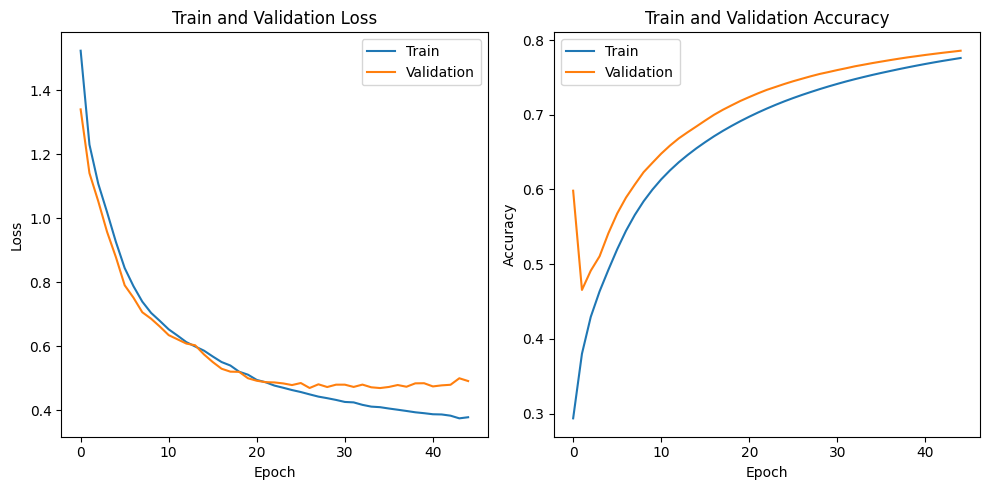

In [12]:
METRICS_PATH = "./logs_task/v2/lightning_logs/version_2"
metrics_task = pd.read_csv(METRICS_PATH + "/metrics.csv")
metrics_task.set_index("epoch", inplace=True)
metrics_task = metrics_task.groupby(level=0).sum().drop("step", axis=1)

plt.rcParams["figure.figsize"] = (10, 5)

plt.subplot(1,2,1)
epochs = len(metrics_task)-1
print(epochs)
plt.plot(metrics_task["train_loss"][0:epochs-1])
plt.plot(metrics_task["val_loss"][0:epochs-1])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Train and Validation Loss")
plt.legend(["Train", "Validation"]);

plt.subplot(1,2,2)

plt.plot(metrics_task["train_acc"][0:epochs-1])
plt.plot(metrics_task["val_acc"][0:epochs-1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Train and Validation Accuracy")
plt.legend(["Train", "Validation"]);

plt.tight_layout();

In [8]:
# Concatenate the predictions from multiple batches
model_cnn.eval()
predictions = trainer_task.predict(model_cnn,test_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Dylan\anaconda3\envs\pytorch\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Output()

In [9]:
test_outputs = torch.cat([prediction[1] for prediction in predictions], dim=0)  # Concatenate model outputs
test_labels = torch.cat([prediction[3] for prediction in predictions], dim=0)  # Concatenate true labels
test_inputs = torch.cat([prediction[2] for prediction in predictions], dim=0)  # Concatenate input images
test_preds = torch.cat([prediction[0] for prediction in predictions], dim=0)#test_outputs.argmax(dim=1)  # Find the index of the maximum probability along the classes (predicted labels)

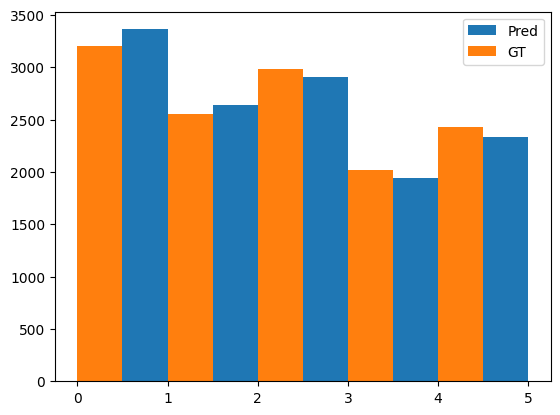

tensor(0.8432)


In [10]:
plt.hist(test_preds+0.5,bins=[0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5],label="Pred");
plt.hist(test_labels,bins=[0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5],label="GT");
plt.legend()
plt.show()

print(torch.where(test_preds==test_labels,1,0).sum()/len(test_labels))

In [11]:
#GradCAM
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image
   

def saliency(index,plot=False, save_plot=False):
    # Retrieve the input image, true label, model output, predicted label for the selected index
    pred = test_preds[index]
    label = test_labels[index]
    output = test_outputs[index]
    image_original = test_inputs[index]

    # Add a batch dimension to the input image (via .unsqueeze()) and set requires_grad to True for saliency analysis
    image = image_original.unsqueeze(0)
    image.requires_grad = True

    # Compute the scores and gradients for the input image
    # To compute the scores, do a forward pass of the image and then take the argmax
    # Use this index to extract the score_max value from "scores"
    # Then perform a backward step so that it backpropagates the gradient
    scores = model_cnn.forward(image)
    score_max_index = torch.argmax(scores)
    score_max = scores[0, score_max_index]
    score_max.backward() # Do the backward step here for the gradient calculation

    # Calculate the saliency map by finding the maximum absolute gradient values across channels
    # You can use .abs() and torch.max()
    grad = image.grad
    grad_abs = torch.squeeze(grad.abs())
    grad_max = torch.max(grad_abs,dim=0).values
    #Unnormalise Image for display
    clean_img = []
    for ch in range(3):
        ch_layer = image_original[ch]
        corrected_layer = ch_layer*stds[ch]+means[ch]
        clean_img.append(corrected_layer.abs())
    clean_img = torch.tensor(np.array(clean_img)).permute(1,2,0)
    clean_img = np.array(clean_img)

    model = model_cnn
    model.eval()

    targets = [ClassifierOutputTarget(label.item())] #0-5
    target_layers = [model.conv_blk2.conv2]
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cams = cam(input_tensor=image, targets=targets)
        cam_image = show_cam_on_image(clean_img, grayscale_cams[0, :], use_rgb=True)
    cam = np.uint8(255*grayscale_cams[0, :])
    cam = cv2.merge([cam, cam, cam])


    # # Create a subplot to display the original image and saliency map side by side
    if plot or save_plot:
        # images = np.hstack((cam , cam_image))
        # grad_cam = Image.fromarray(images)
        actions_list = ["INT","Right","Left","Down","Up",]
        plt.close()
        plt.figure()

        # Create a subplot to display the original image and saliency map side by side
        plt.rcParams["figure.figsize"] = (10, 10)
        plt.subplot(2,2,1)
        plt.imshow(grad_max)
        plt.title(f"Saliency (Max)\nPred: {actions_list[pred.item()]}, GT: {actions_list[label.item()]}, Index: {index}")
        plt.axis('off')

        #GradCAM Plot
        plt.subplot(2,2,4)
        plt.imshow(cam)
        plt.title(f"GradCAM\nPred: {actions_list[pred.item()]}, GT: {actions_list[label.item()]}, Index: {index}")
        plt.axis('off')

        plt.subplot(2,2,3)
        plt.imshow(cam_image)
        plt.title(f"GradCAM Overlay\nPred: {actions_list[pred.item()]}, GT: {actions_list[label.item()]}, Index: {index}")
        plt.axis('off')

        #Original Image
        plt.subplot(2,2,2)
        plt.title(f"Original (Blue)\nPred: {actions_list[pred.item()]}, GT: {actions_list[label.item()]}, Index: {index}")
        plt.imshow((clean_img))
        plt.axis('off')

        if plot:
            plt.show()
            print("Probabilities:",torch.nn.functional.softmax(output))

        if save_plot:
            plt.savefig(fname=f"./results/v2/{index}.png")
        
    return grad_max, cam, image_original

In [24]:
grad_stats = []
cam_stats = []
input_stats = []
for index in range(len(test_labels)):
    grad_stat, cam_stat, _ = saliency(index, False, False)
    grad_stats.append(np.array(grad_stat,dtype="float16"))
    cam_stats.append(np.array(cam_stat,dtype="float16"))


np.save("./results/v2/stats.npy",np.array(grad_stats))
np.save("./results/v2/stats_gradcam.npy",np.array(cam_stats))

In [23]:
np.random.seed(1234)
results_indices = np.random.randint(0,len(test_labels),size=100)
print(results_indices)
for res in results_indices:
    count =0
    for res2 in results_indices:
        if res==res2:
            count+=1
        if count>1:
            print("dupes", res)
            break

# for index in results_indices:
#     grad_stat = saliency(index, False, True)


[11055  8915  1318  7221 11468  7540   664  6137  6833  8471  9449  7322
  8222  1182  7916  8060  7962 10682 10360  7644 11589 11600  9161  2431
   246  2558  3503  5682  3824  5883  5196 12198  1530 10983  7307  6784
  4841 12107 10576     3  1282  1299 11148  6603  4467  3691 11278  3315
 10695 12092  8682  6763  4014  7068  3153  9047  9997  4212 12896 11148
 12485   625  3039  8165 11935  8953 11865  9300 10285  2576 12329 12216
  5206  8108   986 11219  2351  5138  9813  9902  2530 12069  6950 12423
  3044  1731  1774  2607  3062 10484 10614  8879  9103  2594    10  3356
  5124  2130  4199 10585]
dupes 11148
dupes 11148
